In [1]:
import os
import glob
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import shutil
import PIL

Using TensorFlow backend.


In [2]:
dirpath =  "/media/hdd1/dataset/dataprep"
!ls -l /media/hdd1/dataset/dataprep

total 472
drwxr-xr-x 2 sdutta sdutta 225280 Jun 10 16:59 BrunoMars
drwxr-xr-x 2 sdutta sdutta 188416 Jun 10 17:00 KatyPerry
drwxr-xr-x 2 sdutta sdutta  69632 Jun 10 17:12 TaylorSwift


In [4]:
bm = glob.glob("/media/hdd1/dataset/dataprep/BrunoMars/*")
kp = glob.glob("/media/hdd1/dataset/dataprep/KatyPerry/*")
ts = glob.glob("/media/hdd1/dataset/dataprep/TaylorSwift/*")
shk = glob.glob("/media/hdd1/dataset/dataprep/Shakira/*")
len(bm),len(kp),len(ts), len(shk)

(2467, 2859, 705, 0)

In [5]:

len(bm) ,load_img(bm[5])

(2467,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360 at 0x7F8C43F60950>)

In [6]:
#Build a Keras Graph
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers  import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [7]:
from keras.utils import multi_gpu_model
import keras
model = Sequential()
#First conv output of 32 layer 3,3 matrix
model.add(Conv2D(64,(3,3), input_shape=(299,299,3), padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
# Second Conv Layes
model.add(Conv2D(128,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(512,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("elu"))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation("elu"))
model.add(Dropout(0.3))
model.add(Dense(3))
model.add(Activation("softmax"))
opt = keras.optimizers.Adagrad(lr=0.001)
#parallel_model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 299, 299, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 299, 299, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 149, 149, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 256)       295168    
__________

In [9]:
batch_size = 10
train_datagen =  ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:

train_generator = train_datagen.flow_from_directory('/media/hdd1/dataset/dataprep',target_size=(299,299),
                                                    batch_size=10, class_mode="categorical")

Found 6031 images belonging to 3 classes.


In [9]:
validation_generator = test_datagen.flow_from_directory(
        '/media/hdd1/dataset/dataprep',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')

Found 6032 images belonging to 3 classes.


In [18]:
import os
import re

def rename_badfiles():
    badfiles = glob.glob("/media/hdd1/dataset/dataprep/*/._*.jpg")
    for badname in badfiles:
        names =  badname.split("/")
        fname = names[-1]
        goodname=fname[2:]
        goodname =  re.sub('[^A-Za-z0-9./]+', '', goodname)
        path = names[:-1]
        goodname = "/".join(path) + "/" + goodname
        os.rename(badname, goodname)





In [46]:
import os
import re

def rename_corrupt():
    badfiles = glob.glob("/media/hdd1/dataset/dataprep/Shakira/*(*.jpg")
    for badname in badfiles:
        goodname =  re.sub('[^A-Za-z0-9./]+', '', badname)    
        os.rename(badname, goodname)
    

In [ ]:
from os import listdir
from PIL import Image

def clean_files():
    for filename in listdir('/media/hdd1/dataset/dataprep/TaylorSwift/'):
      if filename.endswith('.jpg'):
        try:
          img = Image.open('/media/hdd1/dataset/dataprep/TaylorSwift/'+filename) # open the image file
          img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
          print('Bad file:', filename) # print out the names of corrupt files
          os.remove("/media/hdd1/dataset/dataprep/TaylorSwift/" + filename)

In [ ]:
import keras
#TBlogger = keras.callbacks.ModelCheckpoint("./logs", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit_generator(train_generator, steps_per_epoch=2500, epochs=20, validation_data=validation_generator, validation_steps=800, callbacks=[early_stopping])



In [21]:
model.save("movie_singer_modelgood.h5")

### Transfer Learning using InceptionV3
- Faster learning rate

In [10]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
import keras
from keras.utils import multi_gpu_model
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
inception_model = keras.applications.InceptionV3(weights='imagenet',
                               include_top=False,
                               pooling=None,
                               input_shape=(299, 299, 3))


inception_model.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_____________________________________

In [11]:

# Freeze convolutional layers
for layer in inception_model.layers:
    #print layer
    layer.trainable = False    
    


In [14]:
transfer_model = Sequential()
transfer_model.add(inception_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation="elu"))
transfer_model.add(Dropout(0.3))
transfer_model.add(Dense(128, activation="elu"))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(3, activation="softmax"))

transfer_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adam(lr=1e-4), metrics=["accuracy"])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
transfer_history = transfer_model.fit_generator(train_generator, steps_per_epoch=2500, epochs=20, validation_data=None, validation_steps=800, callbacks=[early_stopping])

Epoch 1/20
2500/2500 [==============================] - 529s 212ms/step - loss: 0.8676 - acc: 0.6614
Epoch 2/20
   1/2500 [..............................] - ETA: 8:05 - loss: 0.4674 - acc: 0.7000

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: acc,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2500/2500 [==============================] - 517s 207ms/step - loss: 0.6309 - acc: 0.7540
Epoch 3/20
2500/2500 [==============================] - 517s 207ms/step - loss: 0.5283 - acc: 0.7961
Epoch 4/20
2500/2500 [==============================] - 512s 205ms/step - loss: 0.4608 - acc: 0.8219
Epoch 5/20
2500/2500 [==============================] - 511s 204ms/step - loss: 0.4072 - acc: 0.8413
Epoch 6/20
2500/2500 [==============================] - 511s 204ms/step - loss: 0.3763 - acc: 0.8553
Epoch 7/20
2500/2500 [==============================] - 511s 204ms/step - loss: 0.3528 - acc: 0.8652
Epoch 8/20
2500/2500 [==============================] - 509s 204ms/step - loss: 0.3299 - acc: 0.8746
Epoch 9/20
2500/2500 [==============================] - 508s 203ms/step - loss: 0.3149 - acc: 0.8800
Epoch 10/20
2500/2500 [==============================] - 511s 204ms/step - loss: 0.2965 - acc: 0.8872
Epoch 11/20
2500/2500 [==============================] - 512s 205ms/step - loss: 0.2757 - acc: 0.8958

In [19]:
transfer_model.save("models/inception_trained_musicvideo.h5")

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(transfer_model, to_file='inception.png')

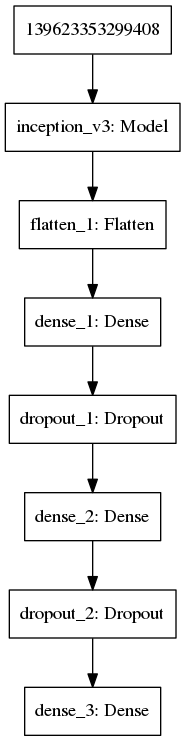

In [21]:
load_img("inception.png")

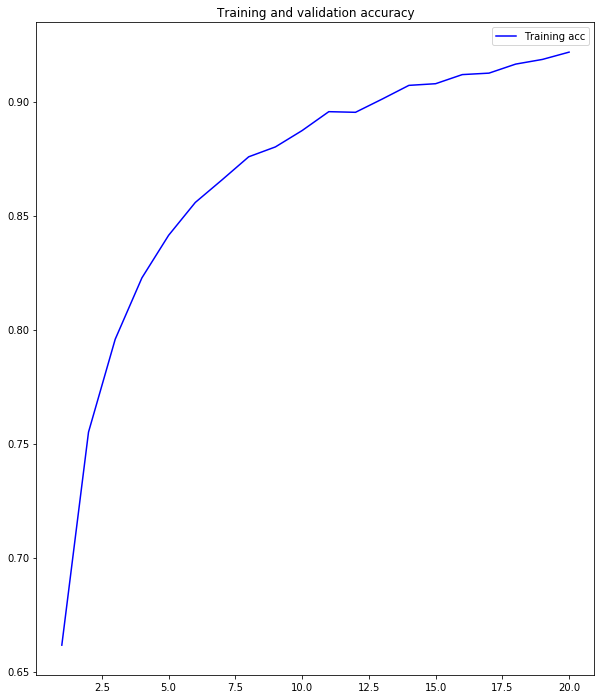

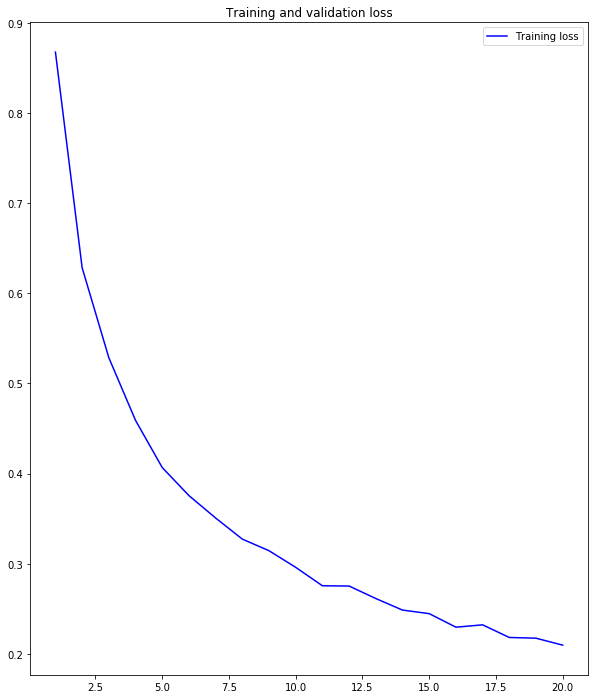

In [24]:
import matplotlib.pyplot as plt

%matplotlib inline
def plot_history(history):
    train_history = history
    acc = train_history.history['acc']
    #val_acc = train_history.history['val_acc']
    loss = train_history.history['loss']
    #val_loss = train_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(10,12))
    plt.plot(epochs, acc, 'blue', label='Training acc')
    #plt.plot(epochs, val_acc, 'red', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    #plt.figure()
    plt.figure(figsize=(10,12))
    plt.plot(epochs, loss, 'blue', label='Training loss')
    #plt.plot(epochs, val_loss, 'red', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.show()

#plt.subplot(2, 1, 1)    
#plot_history(history)
#plt.subplot(2, 1, 2)
plot_history(transfer_history)

In [25]:
!pwd

/media/hdd1/dataset/cats_dogs


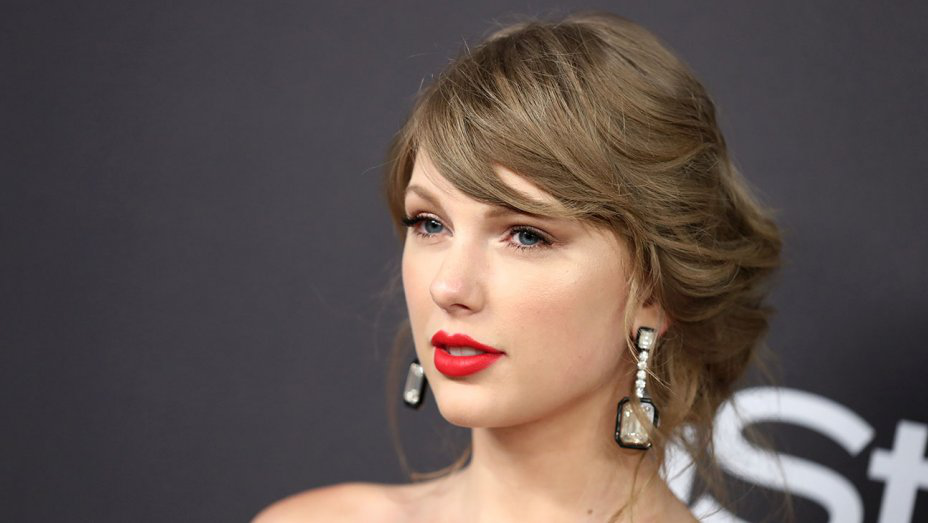

In [26]:
load_img("taylor_swift-getty-h_2019.jpg")

In [27]:
test_generator = test_datagen.flow_from_directory(
        '/media/hdd1/dataset/dataprep',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')

Found 6031 images belonging to 3 classes.


In [42]:
test_generator.

6031

In [1]:
predict = transfer_model.predict_generator(test_generator, steps=10)

NameError: name 'transfer_model' is not defined

In [38]:
train_generator.class_indices

{'BrunoMars': 0, 'KatyPerry': 1, 'TaylorSwift': 2}

In [111]:
from keras.preprocessing import image
#img = image.load_img('taylor_swift-getty-h_2019.jpg', target_size=(299, 299))
img = image.load_img('BrunoMars_Site_NewSite_Assets_FBOG.jpg', target_size=(299, 299))
#img = image.load_img('rihanna-barbados-ambassador.jpg', target_size=(299, 299))
#img = image.load_img("20150205161528-katy-perry.jpeg",target_size=(299, 299,3) )
#img = image.load_img('/media/hdd1/dataset/dataprep/KatyPerry/KatyPerry-Rise(Official)1530.jpg', target_size=(299, 299))
img = image.load_img('adult-beach-casual-736716.jpg', target_size=(299, 299))
x = image.img_to_array(img)
x = x*1.0/255
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = transfer_model.predict_classes(images, batch_size=10)
classes2 = transfer_model.predict(images, batch_size=10)
print classes, classes2

[2] [[0.09208506 0.19898243 0.70893246]]


In [72]:
!ls -l /media/hdd1/dataset/dataprep/TaylorSwift/TaylorSwift-BlankSpace1020.jpg

-rw-r--r-- 1 sdutta sdutta 42270 Jun  8 12:19 /media/hdd1/dataset/dataprep/TaylorSwift/TaylorSwift-BlankSpace1020.jpg


In [71]:
/media/hdd1/dataset/dataprep/

ls: cannot access '/media/hdd1/dataset/dataprep/TaylorSwift-LookWhatYouMadeMeDo1020.jpg': No such file or directory


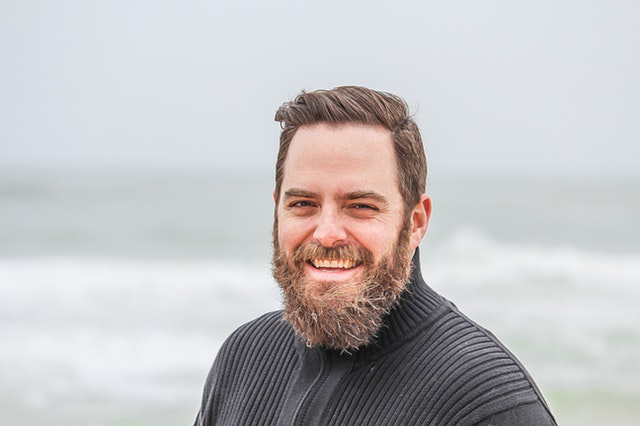

In [104]:
load_img("adult-beach-casual-736716.jpg")

In [102]:
! ls -l "/media/hdd1/dataset/dataprep/KatyPerry/KatyPerry-DarkHorse(Official)ft3660.jpg"

-rw-r--r-- 1 sdutta sdutta 69422 Jun  8 12:19 /media/hdd1/dataset/dataprep/KatyPerry/KatyPerry-DarkHorse(Official)ft3660.jpg


In [98]:
! ls -l /media/hdd1/dataset/dataprep/KatyPerry/

total 149148
-rw-r--r-- 1 sdutta sdutta  62567 Jun  8 12:19 KatyPerry-Birthday(Official)10020.jpg
-rw-r--r-- 1 sdutta sdutta  59497 Jun  8 12:19 KatyPerry-Birthday(Official)10050.jpg
-rw-r--r-- 1 sdutta sdutta  43704 Jun  8 12:19 KatyPerry-Birthday(Official)10080.jpg
-rw-r--r-- 1 sdutta sdutta  42928 Jun  8 12:19 KatyPerry-Birthday(Official)10110.jpg
-rw-r--r-- 1 sdutta sdutta  28270 Jun  8 12:19 KatyPerry-Birthday(Official)10140.jpg
-rw-r--r-- 1 sdutta sdutta  29879 Jun  8 12:19 KatyPerry-Birthday(Official)10170.jpg
-rw-r--r-- 1 sdutta sdutta  66697 Jun  8 12:19 KatyPerry-Birthday(Official)10200.jpg
-rw-r--r-- 1 sdutta sdutta  26661 Jun  8 12:19 KatyPerry-Birthday(Official)1020.jpg
-rw-r--r-- 1 sdutta sdutta  64795 Jun  8 12:19 KatyPerry-Birthday(Official)10230.jpg
-rw-r--r-- 1 sdutta sdutta  26530 Jun  8 12:19 KatyPerry-Birthday(Official)10260.jpg
-rw-r--r-- 1 sdutta sdutta  35506 Jun  8 12:19 KatyPerry-Birthday(Official)10290.jpg
-rw-r--r-- 1 sdutta sdutta  37663 Jun  8 12:19 KatyPe